<a href="https://colab.research.google.com/github/CP2J/cp2j/blob/ACJ-14-Hybrid_Model/RecSys_Hybrid_(MF-DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 하이브리드 추천시스템 (MF_SGD + DL)

In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#rating = pd.read_csv('/content/drive/MyDrive/ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

Mounted at /content/drive


In [3]:
# 데이터 읽어 오기 
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/ml-100k/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

In [4]:
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [5]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# MF-SGD

In [6]:
##### MF-SGD 추천 알고리즘 >>>>>>>>>>>>>>>
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):  # 클래스 생성시 실행되는 초기화 함수
        self.R = np.array(ratings)    # df ratings를 np.array로 바꿔 self.R에 저장

        item_id_index = []    # 변수 초기화
        index_item_id = []    # 변수 초기화
        for i, one_id in enumerate(ratings):        # df ratings의 각 items에 대해서 아래 작업 수행
            item_id_index.append([one_id, i])       # save id - index 
            index_item_id.append([i, one_id])       # save index - id
        self.item_id_index = dict(item_id_index)    # dict로 변환
        self.index_item_id = dict(index_item_id)    # dict로 변환

        user_id_index = []                          # 사용자에 대해서도 실행
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)    # dict로 변환
        self.index_user_id = dict(index_user_id)

        self.num_users, self.num_items = np.shape(self.R)
        self.K = K                                  # 잠재요인 수
        self.alpha = alpha                          # 학습률
        self.beta = beta                            # 정규화계수
        self.iterations = iterations                # SGD 계산 반복 횟수
        self.verbose = verbose                      # 중간 학습과정 출력여부

    # train set의 RMSE 계산
    def rmse(self):                            # 현재 P,Q로 RMSE 계산
        xs, ys = self.R.nonzero()              # R에서 평점이 있는(NOT NULL) 요소의 인덱스들
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):                            # 평점이 있는 요소(사용자 x, 아이템 y)에 대해:
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)             # 예측값을 예측리스트에,
            self.errors.append(self.R[x, y] - prediction)   # 오차를 오차리스트에 저장
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Predict Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)    # 평점 예측치(r^)의 식에 사용자, 아이템 편향 추가한 식
        # b : 전체평균, b_u[i] : 사용자i 평가경향(bias), b_d[j] : 아이템j 평가경향, 넷째항 : P, Q.T를 내적한 예측평점
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:                # samples의 (user-item-rating) set에 대해 sgd적용
            prediction = self.get_prediction(i, j)
            e = (r - prediction)                    # 오차 = 실제평점 - 예측

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])     # 사용자,아이템의 경향성을 고려된 평점예측식의 편미분식으로 사용자 평가경향 업데이트
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])     # 아이템 평가경향 업데이트

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])   # 정규화항 추가된 평점예측식의 편미분식으로 P행렬 업뎃
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])   # Q 업뎃

    # Test set을 선정 - 분리된 test set을 넘겨받아서 클래스 내부의 test set을 만드는 함수
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x = self.user_id_index[ratings_test.iloc[i, 0]]   # 현재 사용자의 인덱스를 user_id_index(매핑 리스트)에서 받아옴
            y = self.item_id_index[ratings_test.iloc[i, 1]]   # 현재 아이템의 인덱스를 item_id_index(매핑 리스트)에서 받아옴
            z = ratings_test.iloc[i, 2]                       # 현재 (사용자-아이템)의 평점
            test_set.append([x, y, z])          # 현재 (사용자-아이템-평점)을 test_set에 추가
            self.R[x, y] = 0                    # Setting test set ratings to 0 : MF는 R 전체를 사용해서 학습하기 때문에 test set은 평점을 지움
        self.test_set = test_set                # test_set을 클래스에 저장한다.
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)       # 오차(평점 실제값 - 예측평점)의 제곱을 누적한 값이 저장된다.
        return np.sqrt(error/len(self.test_set))          # error를 RMSE로 변환해서 돌려준다.

    # Training 하면서 test set의 정확도를 계산
    def test(self):   # MF모델을 SGD방식으로 훈련하는 핵심 함수이다.
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))   # P행렬을 (평균 0, 표준편차 1/K인 정규분포 난수)로 초기화한다.
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))   # Q행렬 초기화한다.

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)           # 사용자 평가경향을 초기화, array크기는 사용자수(num_users)와 동일하다.
        self.b_d = np.zeros(self.num_items)           # 아이템 평가경향을 초기화한다.
        self.b = np.mean(self.R[self.R.nonzero()])    # 전체 평균을 구해서 저장한다.

        # List of training samples
        rows, columns = self.R.nonzero()              # 평점행렬 R 중에서 평점있는 요소의 인덱스를 가져온다.
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]   
        # SGD를 적용할 대상, 즉 평점이 있는 요소의 인덱스와 평점을 리스트로 만들어 samples에 저장한다.

        # Stochastic gradient descent for given number of iterations
        training_process = []                             # training_process 를 초기화한다. SGD를 한번 실행할 때마다 RMSE가 얼마나 개선되는지를 기록한다.
        for i in range(self.iterations):                  # 지정된 반복 횟수만큼 SGD를 실행한다.
            np.random.shuffle(self.samples)               # samples 를 임의로 섞는다. 출발점에 따라 수렴의 속도가 달라질 수 있기 때문이다.
            self.sgd()                                    # SGD를 실행하는 함수를 호출한다.
            rmse1 = self.rmse()                           # SGD로 P, Q, bu, bd가 업데이트 되었으므로 이에 따른 RMSE를 계산한다.
            rmse2 = self.test_rmse()                      # test set은 별도로 계산한다.
            training_process.append((i+1, rmse1, rmse2))  # 결과를 저장한다.
            if self.verbose:                              # verbose가 True이면 10회 반복마다 중간 결과를 표시한다.
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        prediction = self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])
        return prediction

    # Full user-movie rating matrix (모든 사용자의 모든 아이템에 대한 예측치(Full matrix)를 계산해서 돌려준다)
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)
        # $\hat{r}_{ij}=b+bu_i+bd_j+\sum_{k=1}^Kp_{ik}q_{kj}$


In [7]:
# MF클래스 생성 및 학습
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)    # 전체 데이터를 full matrix로 변환한다.
mf = NEW_MF(R_temp, K=200, alpha=0.001, beta=0.02, iterations=300, verbose=True)          # NEW-MF 클래스를 생성한다.
test_set = mf.set_test(ratings_test)    # ratings_test를 테스트 데이터로 지정하도록 set_test() 함수를 호출한다.
result = mf.test()                      # 정해진 파라미터에 따라 MF 훈련과 정확도 계산을 실행한다.

Iteration: 10 ; Train RMSE = 0.9664 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9420 ; Test RMSE = 0.9644
Iteration: 30 ; Train RMSE = 0.9313 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9253 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9214 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9186 ; Test RMSE = 0.9480
Iteration: 70 ; Train RMSE = 0.9165 ; Test RMSE = 0.9468
Iteration: 80 ; Train RMSE = 0.9147 ; Test RMSE = 0.9459
Iteration: 90 ; Train RMSE = 0.9130 ; Test RMSE = 0.9451
Iteration: 100 ; Train RMSE = 0.9111 ; Test RMSE = 0.9444
Iteration: 110 ; Train RMSE = 0.9088 ; Test RMSE = 0.9435
Iteration: 120 ; Train RMSE = 0.9056 ; Test RMSE = 0.9423
Iteration: 130 ; Train RMSE = 0.9010 ; Test RMSE = 0.9405
Iteration: 140 ; Train RMSE = 0.8945 ; Test RMSE = 0.9380
Iteration: 150 ; Train RMSE = 0.8859 ; Test RMSE = 0.9348
Iteration: 160 ; Train RMSE = 0.8753 ; Test RMSE = 0.9312
Iteration: 170 ; Train RMSE = 0.8630 ; Test RMSE = 0.9276
Iteration: 180 ; Train 

# DL

In [8]:
##### (1)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [9]:
# Variable 초기화
K = 200                               # Latent factor(잠재요인) 수
mu = ratings_train.rating.mean()      # 전체 평균
M = ratings.user_id.max() +1          # 사용자 아이디 최대값+1 : Number of users로 간주, 추후 Embedding에 사용
# 사용자 아이디는 1부터 943이지만(위 describe 참고)
# adding 1 ensures that all user IDs from 0 to the maximum ID are included in the embedding layer.
N = ratings.movie_id.max() +1         # Number of movies

# RMSE 정의
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [10]:
##### (2)
# Keras model
user = Input(shape=(1, ))                                             # 사용자 데이터 입력 형식 지정(id만 받음)
item = Input(shape=(1, ))                                             # 아이템 데이터 입력 형식 지정(id만 받음)
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)      # 사용자 Embedding layer 지정 (M, 1, K) : (M X K)의 연결을 가진다.
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)      # 아이템 Embedding layer 지정 (N, 1, K) : (N X K)의 연결을 가진다.
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)        # User bias term (M, 1, ) : (M X 1)의 연결
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)        # Item bias term (N, 1, ) : (N X 1)의 연결

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation    # 나중에 layer 구성에서 사용할 메소드 로드
P_embedding = Flatten()(P_embedding)          # (K, )
Q_embedding = Flatten()(Q_embedding)          # (K, )
user_bias = Flatten()(user_bias)              # (1, )
item_bias = Flatten()(item_bias)              # (1, )
# Concatenate() 위해서 1차원으로 줄인다.
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])   # (2K+2, )
# P, Q, 사용자 bias, 아이템 bias를 붙여서 하나의 layer를 만든다.

# Neural network
R = Dense(2048)(R)              # 노드가 2048개인 dense layer 추가
R = Activation('relu')(R)       # 이 layer의 activation 함수 : 'relu'
R = Dense(256)(R)               # 노드가 256개인 dense layer 하나 더 추가
R = Activation('linear')(R)     # 이 layer의 activation 함수 : 'linear'
R = Dense(1)(R)                 # 노드가 1개인 dense layer를 하나 더 추가 한다. 이 layer가 출력에 연결된다.

# Model setting : 위의 신경망과 입력을 연결해서 모델을 구성한다.
model = Model(inputs = [user, item], outputs = R)
model.compile(
    loss = RMSE,                # loss함수
    optimizer = SGD(),
    #optimizer = Adamax(),
    metrics = [RMSE]            # 측정지표
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [11]:
# Model fitting (위에서 구성한 신경망을 학습시킨다)
result = model.fit(
    x = [ratings_train.user_id.values, ratings_train.movie_id.values],
    # 입력(독립변수)은 train set의 사용자, 아이템 id
    y = ratings_train.rating.values - mu,
    # 출력(종속변수)은 평점에서 전체평균을 뺀 것으로 지정
    epochs = 65,              # 반복횟수
    batch_size = 512,         # 한번에 학습(연산)하는 batch 크기를 지정
    validation_data = (
      [ratings_test.user_id.values, ratings_test.movie_id.values],  # 검증을 위한 입력
      ratings_test.rating.values - mu                               # 검증에 쓰이는 출력
    )
)

Epoch 1/65
147/147 [==============================] - 7s 9ms/step - loss: 5.3960 - RMSE: 1.1254 - val_loss: 5.2705 - val_RMSE: 1.1251
Epoch 2/65
147/147 [==============================] - 1s 5ms/step - loss: 5.1512 - RMSE: 1.1244 - val_loss: 5.0329 - val_RMSE: 1.1243
Epoch 3/65
147/147 [==============================] - 1s 5ms/step - loss: 4.9202 - RMSE: 1.1232 - val_loss: 4.8090 - val_RMSE: 1.1235
Epoch 4/65
147/147 [==============================] - 1s 5ms/step - loss: 4.7026 - RMSE: 1.1224 - val_loss: 4.5977 - val_RMSE: 1.1227
Epoch 5/65
147/147 [==============================] - 1s 5ms/step - loss: 4.4973 - RMSE: 1.1216 - val_loss: 4.3986 - val_RMSE: 1.1220
Epoch 6/65
147/147 [==============================] - 1s 4ms/step - loss: 4.3038 - RMSE: 1.1208 - val_loss: 4.2106 - val_RMSE: 1.1210
Epoch 7/65
147/147 [==============================] - 1s 5ms/step - loss: 4.1211 - RMSE: 1.1201 - val_loss: 4.0335 - val_RMSE: 1.1203
Epoch 8/65
147/147 [==============================] - 1s 5ms/s

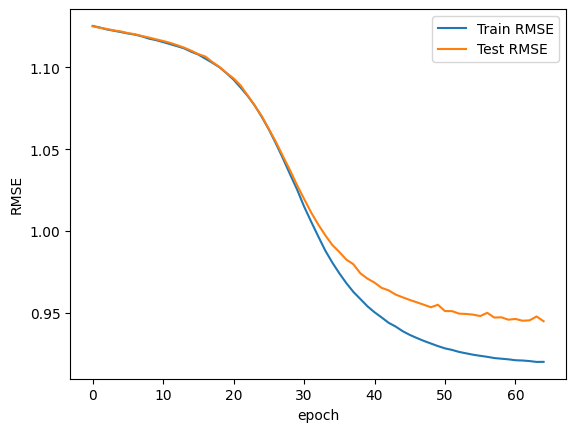

In [12]:
# 학습과정에서 측정지표의 변화
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [13]:
# 신경망에서 예측한 결과의 실제 RMSE 계산
def RMSE2(y_true, y_pred):
    return np.sqrt( np.mean( ( np.array(y_true) - np.array(y_pred) )**2 ) )

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
# Keras의 Model 클래스에서 제공하는 predict() 메소드는 신경망에 입력을 넣어주면 해당 신경망을 적용한 예측값을 계산해준다.
y_pred = np.ravel(y_pred, order = 'C')
# predict()로 얻은 예측값은 2차원(N X 1)의 array로 되어있으므로 np.ravel을 사용, 1차원 array로 바꿔준다.
y_true = np.array(ratings_test.rating)
# 실제 평점값을 가져온다.
RMSE2(y_true, y_pred)

782/782 [==============================] - 2s 2ms/step


0.9450759256957006

# 하이브리드 모델

In [14]:
##### Hybrid 추천 알고리즘

def recommender0(recomm_list, mf):              # MF 알고리즘의 예측값을 받아오는 함수이다. 
    recommendations = np.array([mf.get_one_prediction(user, movie) for (user, movie) in recomm_list])
    # 추천대상 리스트(recomm_list)의 항목 각각에 대해서 MF클래스의 get_one_prediction() 함수를 불러서 예측값을 받아온 후에 np.array로 변환한다.
    return recommendations

def recommender1(recomm_list, model):           # DL 알고리즘의 예측값을 받아오는 함수이다.
    for (user, movie) in recomm_list:
      recommendations = model.predict([user, movie]) + mu
      # 추천대상 리스트(recomm_list)의 항목 각각에 대해서 Keras의 Model 클래스에서 제공하는 predict() 메소드는 신경망에 입력을 넣어주면 
      # 해당 신경망을 적용한 예측값을 계산해준다. 
      recommendations = np.ravel(recommendations, order = 'C')
      # predict()로 얻은 예측값은 2차원(N X 1)의 array로 되어있으므로 np.ravel을 사용, 1차원 array로 바꿔준다.
      # 예측값을 받아온 후에 np.array로 변환한다.
    return recommendations

recomm_list = np.array(ratings_test.iloc[:, [0, 1]])      # test set을 np.array형식의 추천 대상 리스트로 만든다.
predictions0 = recommender0(recomm_list, mf)              # MF기반 알고리즘의 예측값을 받아온다.
RMSE(ratings_test.iloc[:, 2], predictions0)               # MF기반 알고리즘의 RMSE를 계산한다.
predictions1 = recommender1(recomm_list, model)           # DL기반 알고리즘의 예측값을 받아온다.
RMSE(ratings_test.iloc[:, 2], predictions1)               # DL기반 알고리즘의 RMSE를 계산한다.

weight = [0.8, 0.2]                                                 # 두 알고리즘의 결합 가중치를 지정한다.
predictions = predictions0 * weight[0] + predictions1 * weight[1]   # 가중치에 따라 두 추천 알고리즘에서 가져온 예측값을 가중평균한다.
RMSE(ratings_test.iloc[:, 2], predictions)                          # 하이브리드 모델의 RMSE를 계산한다.

ValueError: ignored

In [ ]:
# 가중치를 0~1까지 0.01 간격으로 바꿔가면서 RMSE 계산
for i in np.arange(0, 1, 0.01):
    weight = [i, 1.0 - i]
    predictions = predictions0 * weight[0] + predictions1 * weight[1]
    print("Weights - %.2f : %.2f ; RMSE = %.7f" % (weight[0], 
           weight[1], RMSE(ratings_test.iloc[:, 2], predictions)))

- 베스트 : Weights - 0.91 : 0.09 ; RMSE = 0.9069064


                    (MF-SGD 91%, DL   %)